# 2-Hop Hypothesis Testing: Sampling Experiments

This notebook tests the 2-hop hypothesis for spatial reasoning:
1. **First hop**: Text tokens look at the image (last token ignores it)
2. **Second hop**: Information flows from text tokens to the last token

We sample N samples per position (4 positions) and compute statistics.

In [1]:
import sys
sys.path.append('..')

import pickle
import pandas as pd
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from datasets import load_from_disk
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor, AutoTokenizer
from collections import defaultdict
from tqdm.auto import tqdm

# Import mechanistic analysis utilities
from mechanistic.utils.two_hop_metrics import (
    compute_all_two_hop_metrics,
    print_metrics_summary,
    identify_token_ranges,
)
from mechanistic.utils.two_hop_visualization import (
    plot_attention_distribution_comparison,
    plot_attention_flow,
    plot_hub_tokens_analysis,
    plot_direct_vs_indirect,
)

%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [2]:
# Configuration
N_SAMPLES_PER_POSITION = 32

# Paths
model_path = "/leonardo_work/EUHPC_D27_102/compmech/models/Qwen3-VL-4B-Instruct"
dataset_path = Path('/leonardo_work/EUHPC_D27_102/spatialmech/dataset/controlled_b.hf/')
results_path = Path('../output/controlled_b.hf_results.csv')

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Load dataset with images
print(f"Loading dataset from {dataset_path}...")
dataset = load_from_disk(str(dataset_path))
FULL_POSITIONS = set(dataset['preposition'])

preposition_mapping = {
    'right_of': 'right',
    'left_of': 'left',
    'in-front_of': 'front',
    'behind': 'behind'
}

# Apply the mapping to the dataset
def map_preposition(example):
    example['preposition'] = preposition_mapping.get(example['preposition'], example['preposition'])
    return example

dataset = dataset.map(map_preposition)

POSITIONS = set(dataset['preposition'])
print(f"\nConfiguration:")
print(f"  Samples per position: {N_SAMPLES_PER_POSITION}")
print(f"  Positions: {POSITIONS}")
print(f"  Total samples to analyze: {N_SAMPLES_PER_POSITION * len(POSITIONS)}")

# Show sample
print(f"\nExample sample:")
sample = dataset[0]
for key, value in sample.items():
    if key != 'image':
        print(f"  {key}: {value}")

Loading dataset from /leonardo_work/EUHPC_D27_102/spatialmech/dataset/controlled_b.hf...

Configuration:
  Samples per position: 32
  Positions: {'front', 'behind', 'right', 'left'}
  Total samples to analyze: 128

Example sample:
  caption_correct: A mug to the right of a knife
  caption_incorrect: ['A mug in front of a knife', 'A mug behind a knife', 'A mug to the left of a knife']
  preposition: right
  objects: ['mug', 'knife']


In [ ]:
POSITIONS = [list(set(dataset['preposition']))[0]]
POSITIONS

In [ ]:
# Load results CSV to identify correct predictions
print(f"\nLoading results from {results_path}...")
results_df = pd.read_csv(results_path)

print(f"Loaded {len(results_df)} results")
print(f"\nColumns: {results_df.columns.tolist()}")
print(f"\nCorrect answers: {results_df['correct'].sum()} / {len(results_df)} ({100*results_df['correct'].mean():.1f}%)")

# Check distribution by position
print(f"\nCorrect predictions by position:")
for pos in FULL_POSITIONS:
    pos_df = results_df[results_df['preposition'] == pos]
    n_correct = pos_df['correct'].sum()
    print(f"  {pos}: {n_correct}/{len(pos_df)} ({100*n_correct/len(pos_df):.1f}%)")

## 3. Sample Selection

Select N samples per position (4 positions) from correct predictions.

In [ ]:
def select_samples_by_position(results_df, n_per_position=8, only_correct=True, seed=42):
    """
    Select n samples per position (preposition).
    
    Args:
        results_df: DataFrame with results
        n_per_position: Number of samples per position
        only_correct: Whether to only select correct predictions
        seed: Random seed
    
    Returns:
        Dictionary mapping position to list of sample indices
    """
    # Filter correct predictions if requested
    if only_correct:
        df = results_df[results_df['correct'] == True].copy()
        print(f"Filtering to {len(df)} correct predictions")
    else:
        df = results_df.copy()
    
    selected_samples = {}
    
    for position in FULL_POSITIONS:
        # Filter by position
        position_df = df[df['preposition'] == position]
        print(f"\nPosition '{position}': {len(position_df)} samples available")
        
        # Sample n samples
        if len(position_df) >= n_per_position:
            sampled = position_df.sample(n=n_per_position, random_state=seed)
            selected_samples[position] = sampled['sample_idx'].tolist()
            print(f"  Selected {len(selected_samples[position])} samples: {selected_samples[position]}")
        else:
            # Take all available if not enough
            selected_samples[position] = position_df['sample_idx'].tolist()
            print(f"  WARNING: Only {len(selected_samples[position])} samples available (requested {n_per_position})")
    
    return selected_samples

# Select samples
print(f"Selecting samples...")
selected_samples_dict = select_samples_by_position(
    results_df, 
    n_per_position=N_SAMPLES_PER_POSITION,
    only_correct=True,
    seed=42
)

# Flatten to single list
selected_sample_indices = []
for position, indices in selected_samples_dict.items():
    selected_sample_indices.extend(indices)

print(f"\nTotal samples selected: {len(selected_sample_indices)}")
print(f"Sample indices: {sorted(selected_sample_indices)}")

## 4. Load Model and Run Inference

Run inference on selected samples to extract attention patterns.

In [4]:
def create_question(objects, prepositions, is_one_object=False):
    """
    Create question for the model.
    """
    prep_list = sorted(list(prepositions))
    prep_options = ", ".join(prep_list[:-1]) + f" or {prep_list[-1]}"

    if is_one_object:
        object1 = objects[0] if isinstance(objects, list) else objects
        question = f"Where is the {object1} localized in the image?. Answer with {prep_options}."
    else:
        object1, object2 = objects[0], objects[1]
        question = f"Where is the {object1} in relation to the {object2}? Answer with {prep_options}."

    return question

In [5]:
# Load model and processor
print(f"Loading model from {model_path}...")
# model = Qwen3VLForConditionalGeneration.from_pretrained(
#     model_path, 
#     dtype=torch.bfloat16, 
#     device_map="auto",
#     attn_implementation="eager"
# )
processor = AutoProcessor.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# model.eval()
# print(f"Model loaded on {device}")
# print(f"Model dtype: {model.dtype}")

Loading model from /leonardo_work/EUHPC_D27_102/compmech/models/Qwen3-VL-4B-Instruct...


In [ ]:
def run_inference_with_attentions(model, processor, dataset, sample_indices, device="cuda"):
    """
    Run inference on selected samples and extract attention patterns.
    
    Args:
        model: Model
        processor: Processor
        dataset: Dataset with images
        sample_indices: List of sample indices to process
        device: Device
    
    Returns:
        Dictionary mapping sample_idx to output dict with attentions
    """
    outputs_dict = {}
    prepositions = set(dataset["preposition"])
    
    print(f"Running inference on {len(sample_indices)} samples...")
    
    for idx in tqdm(sample_indices, desc="Processing samples"):
        try:
            # Get sample
            sample = dataset[idx]
            image = sample["image"]
            objects = sample["objects"]
            preposition = sample["preposition"]
            
            # Create question
            question = create_question(objects, prepositions, is_one_object=False)
            
            # Prepare messages
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image", "image": image},
                        {"type": "text", "text": question},
                    ],
                }
            ]
            
            # Prepare inputs
            text = processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )
            inputs = processor(
                text=[text],
                images=[image],
                padding=True,
                return_tensors="pt",
            )
            inputs = inputs.to(device)
            
            # Run inference with attention output
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=10,
                    do_sample=False,
                    output_attentions=True,
                    return_dict_in_generate=True,
                )
            
            # Decode generated text
            input_length = inputs["input_ids"].shape[1]
            generated_text = processor.batch_decode(
                outputs.sequences[:, input_length:],
                skip_special_tokens=True,
                clean_up_tokenization_spaces=False,
            )[0].strip()

            # Move attentions to cpu
            first_token_attentions = outputs.attentions[0]  # First generated token only
            attentions_cpu = tuple([att.cpu() for att in first_token_attentions])
            
            # Store outputs
            output_dict = {
                'sample_idx': idx,
                'input_ids': inputs['input_ids'].cpu(),
                'attentions': attentions_cpu,
                'sequences': outputs.sequences.cpu(),
                'pred': generated_text,
                'GT': preposition,
                'question': question,
                'caption': sample['caption_correct'],
                'objects': objects,
            }
            
            outputs_dict[idx] = output_dict

            # Delete intermediate variables to free GPU memory
            del inputs, outputs, first_token_attentions
            torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"\nError processing sample {idx}: {e}")
            continue
    
    print(f"\nSuccessfully processed {len(outputs_dict)} samples")
    return outputs_dict

# Run inference
outputs_dict = run_inference_with_attentions(
    model, 
    processor, 
    dataset, 
    selected_sample_indices[96:],
    device=device
)

## 5. Process Attention Patterns

Extract attention patterns from the first generated token (the answer token).

In [6]:
import torch
from pathlib import Path

# Define the path and files
base_path = Path('/leonardo_work/EUHPC_D27_102/spatialmech/attn_patterns/')
position_files = ['behind.pt', 'front.pt', 'right.pt', 'left.pt']

# Load and merge all positions
outputs_dict = {}

for file in position_files:
    file_path = base_path / file
    position_data = torch.load(file_path, map_location='cpu')
    print(f"Loaded {len(position_data)} samples from {file}")

    # Merge into main dictionary
    outputs_dict.update(position_data)

print(f"\nTotal samples loaded: {len(outputs_dict)}")
print(f"Sample indices: {sorted(outputs_dict.keys())[:10]}...")

Loaded 32 samples from behind.pt
Loaded 32 samples from front.pt
Loaded 32 samples from right.pt
Loaded 32 samples from left.pt

Total samples loaded: 128
Sample indices: [0, 1, 2, 6, 9, 18, 20, 24, 26, 32]...


In [9]:
from mechanistic.utils.two_hop_metrics import identify_token_ranges
import pandas as pd
from tqdm.auto import tqdm

def create_layer_wise_df(outputs_dict, tokenizer):
  all_data = []

  for sample_idx, output in tqdm(outputs_dict.items()):
      try:
          input_ids = output['input_ids'][0] if output['input_ids'].dim() > 1 else output['input_ids']
          vision_range, text_range = identify_token_ranges(input_ids, tokenizer)

          # Get first token attentions (tuple of layers)
          layer_attentions = output['attentions']

          for layer_idx, attn_avg in enumerate(layer_attentions):
              # Remove batch dim and average heads
            #   if layer_attn.dim() == 4:
            #       layer_attn = layer_attn[0]
            #   attn_avg = layer_attn.mean(dim=0)  # (seq_len, seq_len)

              # Last token attention
              last_attn = attn_avg[-1, :]
              total = last_attn.sum().item()

              all_data.append({
                  'sample_idx': sample_idx,
                  'layer_idx': layer_idx,
                  'image_pct': last_attn[vision_range[0]:vision_range[1]].sum().item() / total * 100,
                  'text_pct': last_attn[text_range[0]:text_range[1]].sum().item() / total * 100,
                  'bos_pct': last_attn[:vision_range[0]].sum().item() / total * 100,
                  'GT': output['GT']
              })
      except Exception as e:
          print(f"Error {sample_idx}: {e}")
          continue

  return pd.DataFrame(all_data)

# Create df and plot
df = create_layer_wise_df(outputs_dict, tokenizer)
print(df.head())

  0%|          | 0/128 [00:00<?, ?it/s]

   sample_idx  layer_idx  image_pct   text_pct    bos_pct      GT
0         131          0  29.882812  67.968750   1.586914  behind
1         131          1  14.062500  73.046875  12.060547  behind
2         131          2  19.921875  46.875000  32.617188  behind
3         131          3  10.009766  50.781250  37.695312  behind
4         131          4   4.467773  54.687500  38.867188  behind


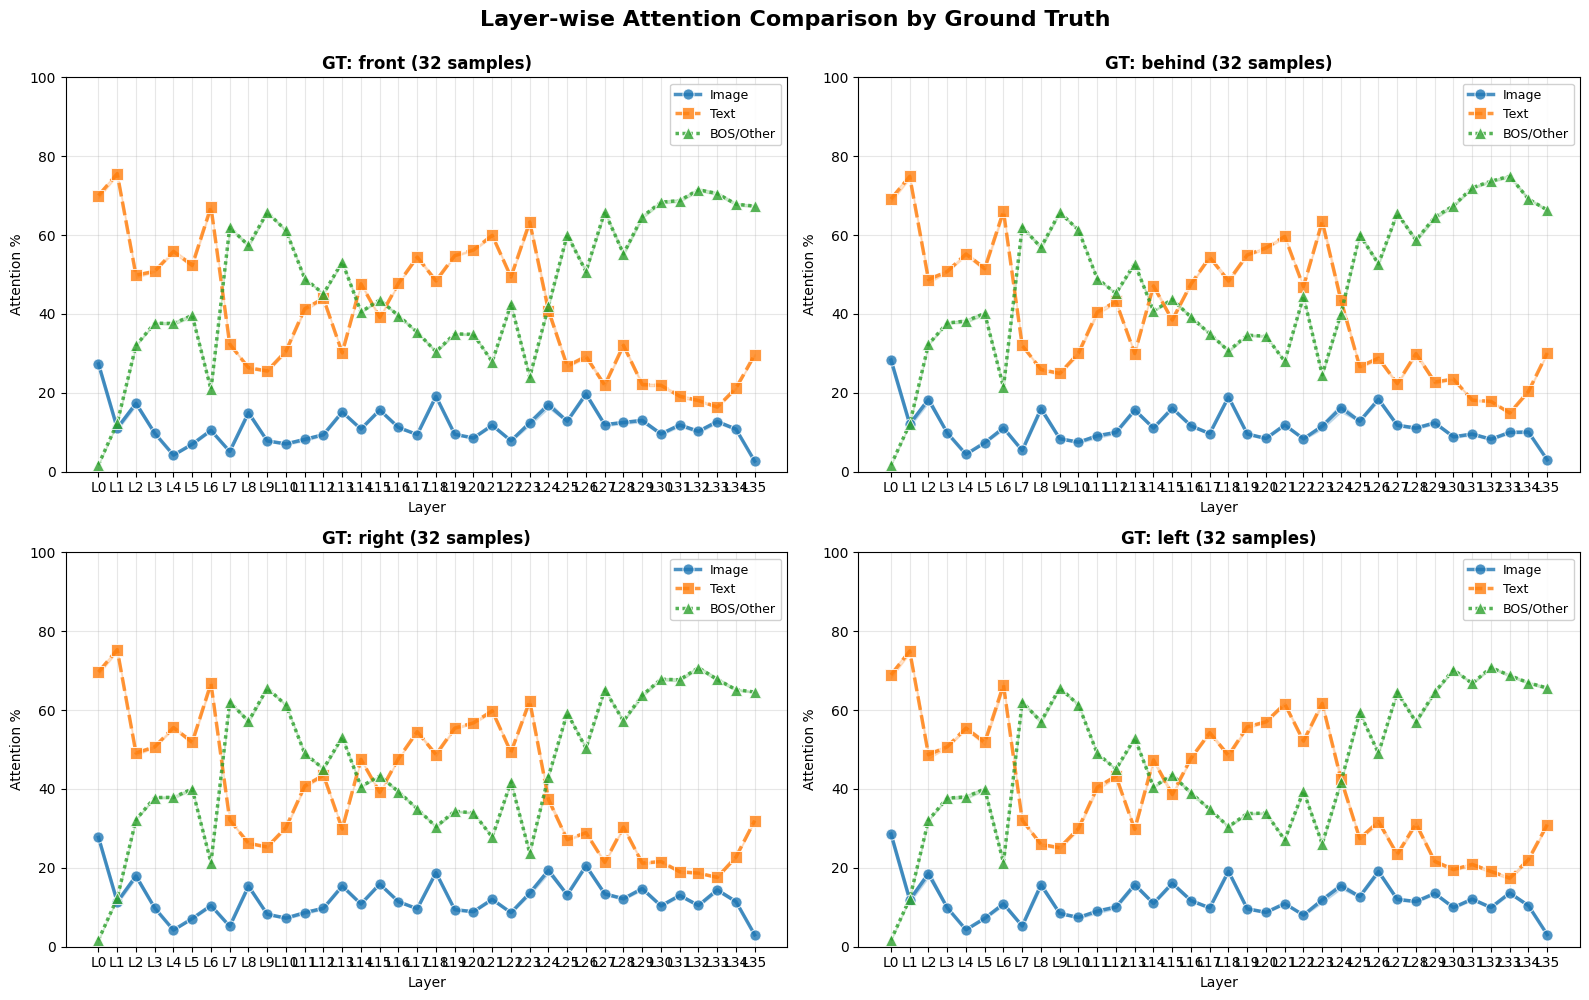

In [10]:
from mechanistic.utils.visualization import plot_layer_wise_attention_comparison

# Create 2x2 subplot comparing all 4 spatial relations
p = plot_layer_wise_attention_comparison(df, gt_values=list(set(dataset['preposition'])))

In [ ]:
from mechanistic.utils.visualization import plot_layer_wise_attention_with_ci
fig = plot_layer_wise_attention_with_ci(df, gt_filter='in-front_of')
#fig.savefig("./in-front_of.png", dpi=300, bbox_inches='tight')
plt.show()

## 6. Token-Level Analysis: Which Text Tokens Does the Last Token Attend To?

Deep dive into which specific text tokens receive attention from the last token across layers.

In [11]:
def get_text_token_attention_details(outputs_dict, tokenizer):
    all_data = []

    for sample_idx, output in tqdm(outputs_dict.items(), desc="Analyzing token-level attention"):
        try:
            input_ids = output['input_ids'][0] if output['input_ids'].dim() > 1 else output['input_ids']
            vision_range, text_range = identify_token_ranges(input_ids, tokenizer)

            # Get text tokens
            text_token_ids = input_ids[text_range[0]:text_range[1]]
            text_token_texts = [tokenizer.decode([tid]) for tid in text_token_ids]

            # Get first token attentions (tuple of layers)
            layer_attentions = output['attentions']

            for layer_idx, attn_avg in enumerate(layer_attentions):
                # Last token attention to ALL tokens
                last_attn_all = attn_avg[-1, :]
                total_attention = last_attn_all.sum().item()

                # Last token attention to text tokens only
                last_attn_text = attn_avg[-1, text_range[0]:text_range[1]]
                text_attention_sum = last_attn_text.sum().item()

                # Store attention for each text token
                for rel_pos, (token_id, token_text, attn_weight) in enumerate(
                    zip(text_token_ids, text_token_texts, last_attn_text)
                ):
                    abs_position = text_range[0] + rel_pos

                    # Raw attention weight (as percentage of total)
                    attention_raw = attn_weight.item()
                    attention_raw_pct = (attention_raw / total_attention * 100) if total_attention > 0 else 0

                    # Renormalized attention weight (as percentage of text attention only)
                    attention_renorm_pct = (attention_raw / text_attention_sum * 100) if text_attention_sum > 0 else 0

                    all_data.append({
                        'sample_idx': sample_idx,
                        'layer_idx': layer_idx,
                        'rel_position': rel_pos,
                        'abs_position': abs_position,
                        'token_id': token_id.item(),
                        'token_text': token_text,
                        'attention_weight_raw': attention_raw,
                        'attention_weight_raw_pct': attention_raw_pct,
                        'attention_weight_renorm_pct': attention_renorm_pct,
                        'text_total_pct': (text_attention_sum / total_attention * 100) if total_attention > 0 else 0,
                        'GT': output['GT']
                    })

        except Exception as e:
            print(f"Error {sample_idx}: {e}")
            continue

    return pd.DataFrame(all_data)

# Create detailed token-level dataframe
print("Extracting text token attention details...")
token_df = get_text_token_attention_details(outputs_dict, tokenizer)
print(f"\nCreated dataframe with {len(token_df)} rows")
print(f"Columns: {token_df.columns.tolist()}")
print(f"\nSample rows:")
print(token_df.head(20))

# Verify renormalization works correctly
print("\nVerification - sum of renormalized attention per layer should be ~100%:")
verification = token_df.groupby(['sample_idx', 'layer_idx'])['attention_weight_renorm_pct'].sum()
print(verification.head(10))
print(f"\nMean sum: {verification.mean():.2f}% (should be ~100%)")

Extracting text token attention details...


Analyzing token-level attention:   0%|          | 0/128 [00:00<?, ?it/s]


Created dataframe with 115200 rows
Columns: ['sample_idx', 'layer_idx', 'rel_position', 'abs_position', 'token_id', 'token_text', 'attention_weight_raw', 'attention_weight_raw_pct', 'attention_weight_renorm_pct', 'text_total_pct', 'GT']

Sample rows:
    sample_idx  layer_idx  rel_position  abs_position  token_id token_text  \
0          131          0             0          1205      9064      Where   
1          131          0             1          1206       374         is   
2          131          0             2          1207       279        the   
3          131          0             3          1208     11968      plate   
4          131          0             4          1209       304         in   
5          131          0             5          1210     12687   relation   
6          131          0             6          1211       311         to   
7          131          0             7          1212       279        the   
8          131          0             8       

### Visualization 1: Heatmap of Top Attended Tokens Per Layer

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_single_sample_text_tokens_per_layer(token_df, sample_idx, outputs_dict=None):
    """
    Plot heatmap of renormalized attention to text tokens across layers for a SINGLE sample.
    Shows actual tokens (not grouped) in prompt order.
    """
    # Filter to single sample
    df_sample = token_df[token_df['sample_idx'] == sample_idx].copy()

    if len(df_sample) == 0:
        print(f"No data found for sample {sample_idx}")
        return None

    # Get unique layers
    layers = sorted(df_sample['layer_idx'].unique())
    n_layers = len(layers)

    # Get token sequence in order (from layer 0)
    layer_0_data = df_sample[df_sample['layer_idx'] == 0].sort_values('rel_position')
    token_labels = layer_0_data['token_text'].tolist()
    n_tokens = len(token_labels)

    # Create matrix: rows = tokens, cols = layers
    matrix = np.zeros((n_tokens, n_layers))

    for layer_idx, layer in enumerate(layers):
        layer_data = df_sample[df_sample['layer_idx'] == layer].sort_values('rel_position')

        for token_idx, row in enumerate(layer_data.itertuples()):
            matrix[token_idx, layer_idx] = row.attention_weight_renorm_pct

    # Create visualization
    fig, ax = plt.subplots(figsize=(max(16, n_layers * 0.6), max(8, n_tokens * 0.3)))

    # Plot heatmap
    im = ax.imshow(matrix, cmap='YlOrRd', aspect='auto', interpolation='nearest')

    # Set ticks
    ax.set_xticks(np.arange(n_layers))
    ax.set_yticks(np.arange(n_tokens))
    ax.set_xticklabels([f"L{i}" for i in layers])
    #ax.set_yticklabels(token_labels, fontsize=9)
    ax.set_yticklabels([repr(token) for token in token_labels], fontsize=9)

    # Rotate x labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, label='Renormalized Attention (%)')

    # Get GT and question info if available
    gt_info = df_sample['GT'].iloc[0] if 'GT' in df_sample.columns else 'N/A'

    title = f"Sample {sample_idx} - GT: {gt_info}"
    if outputs_dict and sample_idx in outputs_dict:
        question = outputs_dict[sample_idx]['question']
        title += f"\n{question}"

    ax.set_title(title, fontsize=12, pad=10)
    ax.set_xlabel("Layer", fontsize=11)
    ax.set_ylabel("Token (Prompt Order)", fontsize=11)

    # Add grid
    ax.set_xticks(np.arange(n_layers) - 0.5, minor=True)
    ax.set_yticks(np.arange(n_tokens) - 0.5, minor=True)
    ax.grid(which="minor", color="white", linestyle='-', linewidth=0.5)

    plt.tight_layout()
    return fig

# Plot for a single sample
example_sample = token_df['sample_idx'].unique()[123]
print(f"Plotting sample: {example_sample}")
fig = plot_single_sample_text_tokens_per_layer(token_df, example_sample, outputs_dict=outputs_dict)
plt.show()

Filtered to 32 samples with GT=front


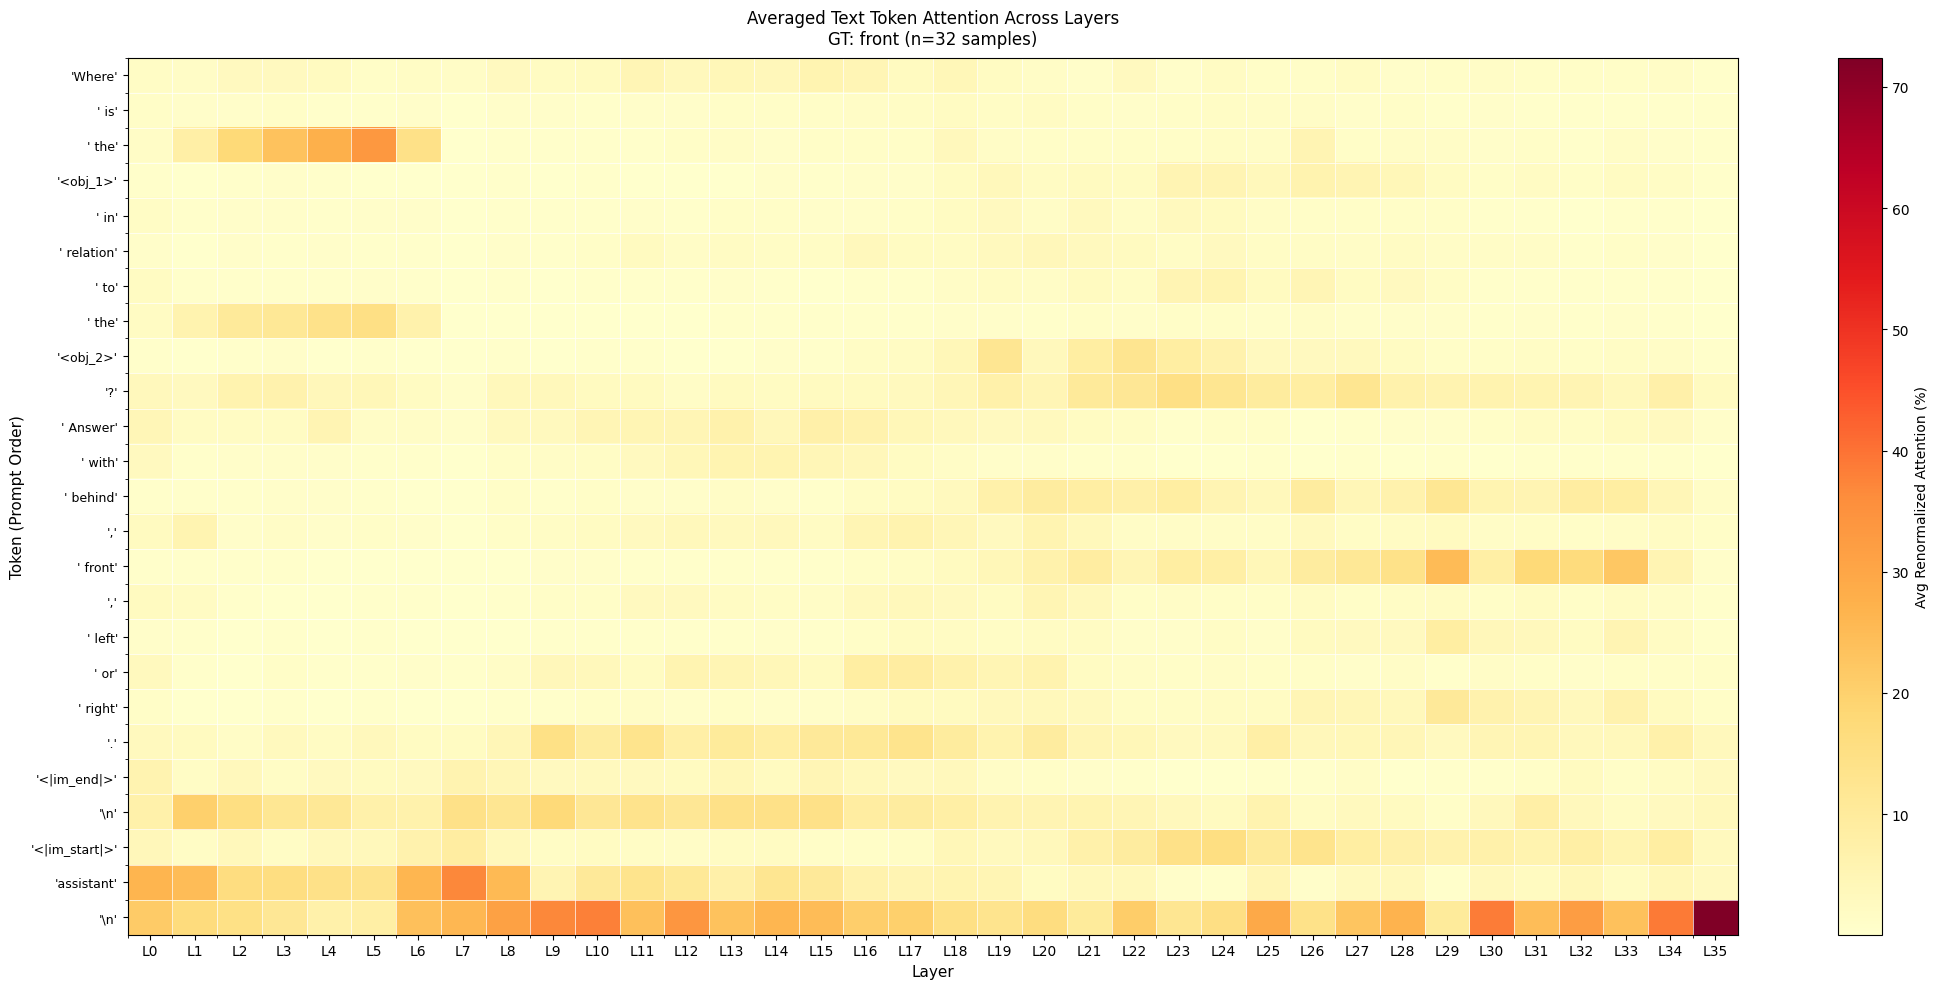

Filtered to 32 samples with GT=behind


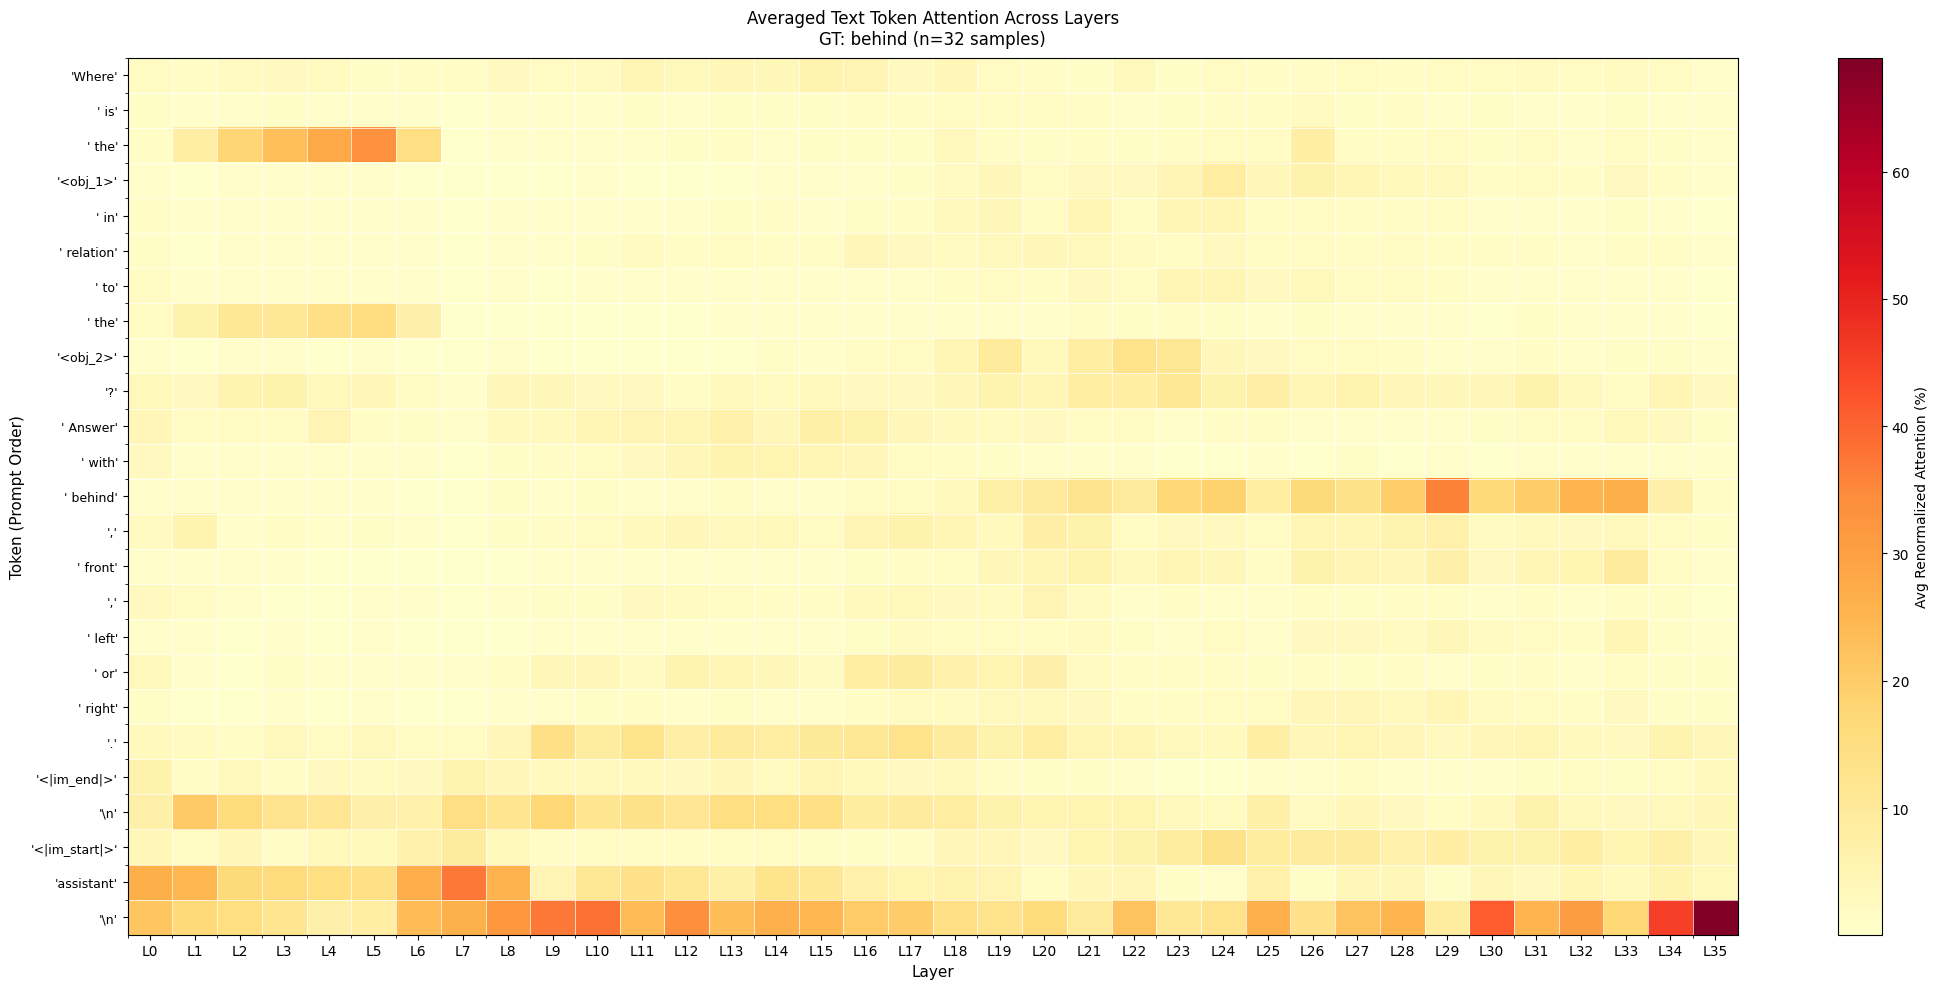

Filtered to 32 samples with GT=left


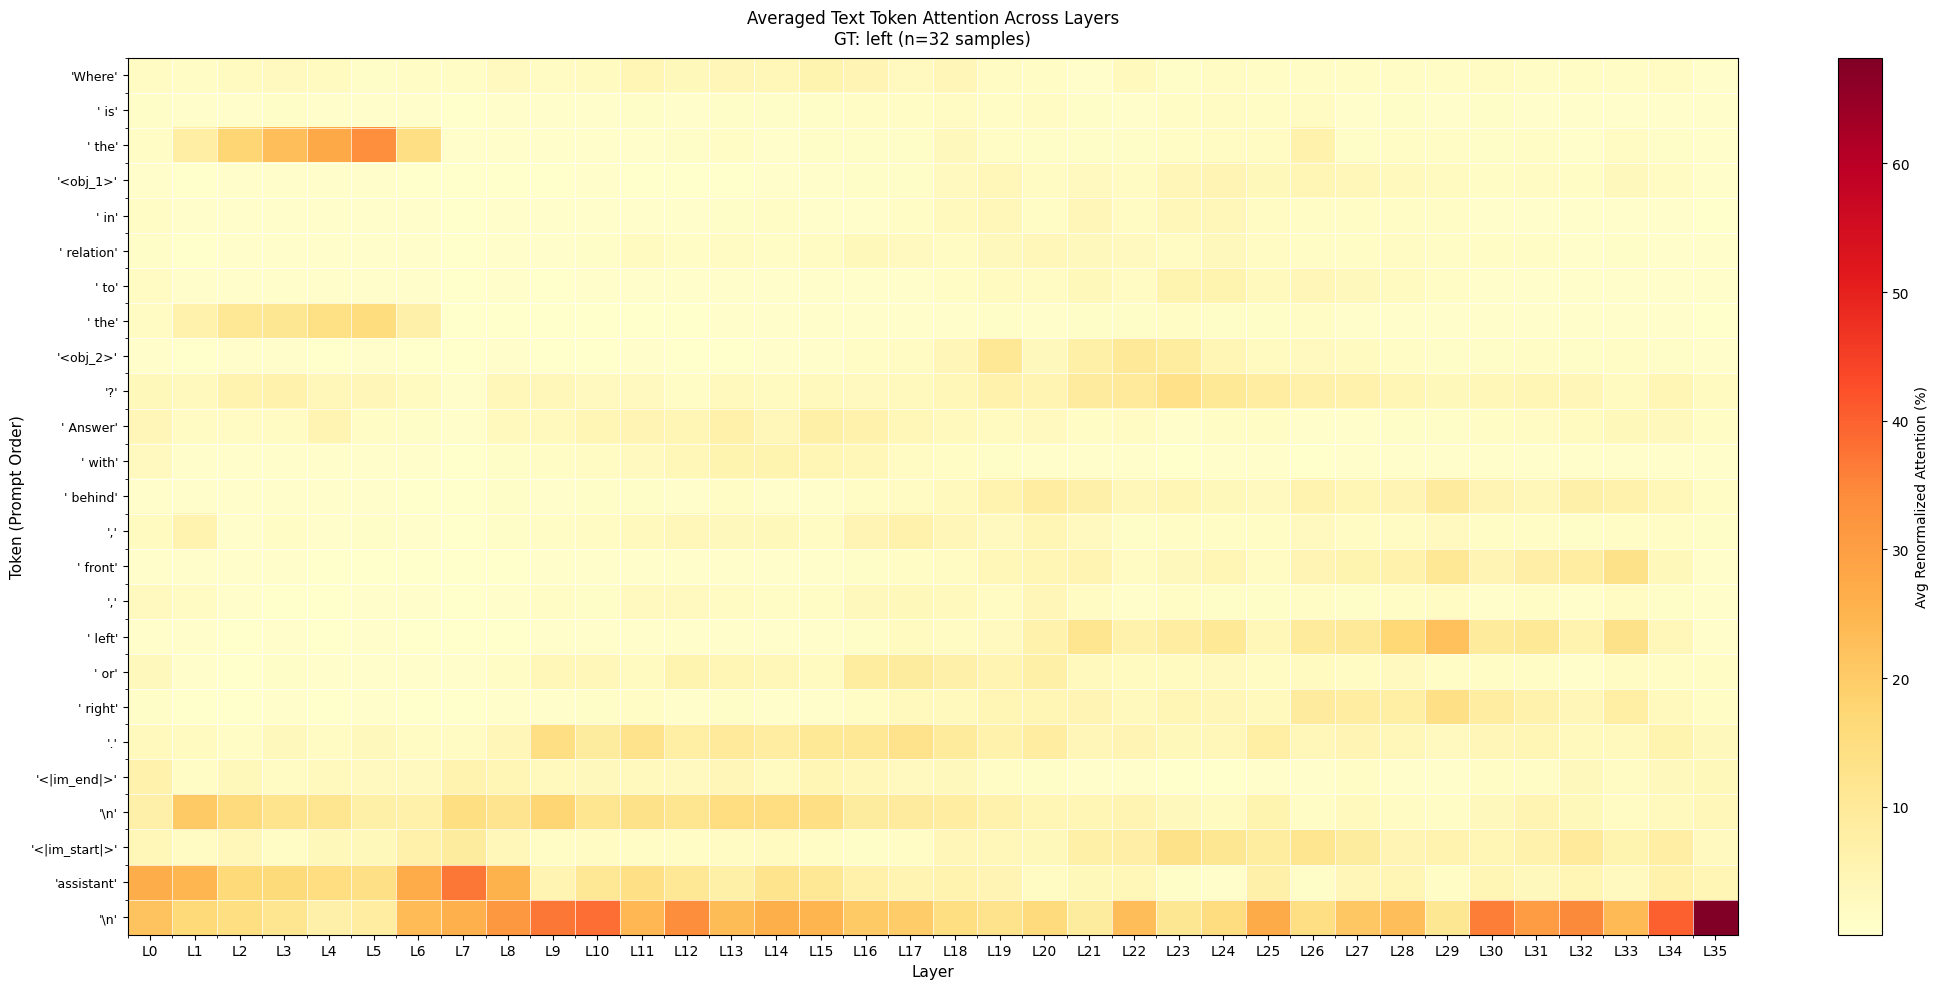

Filtered to 32 samples with GT=right


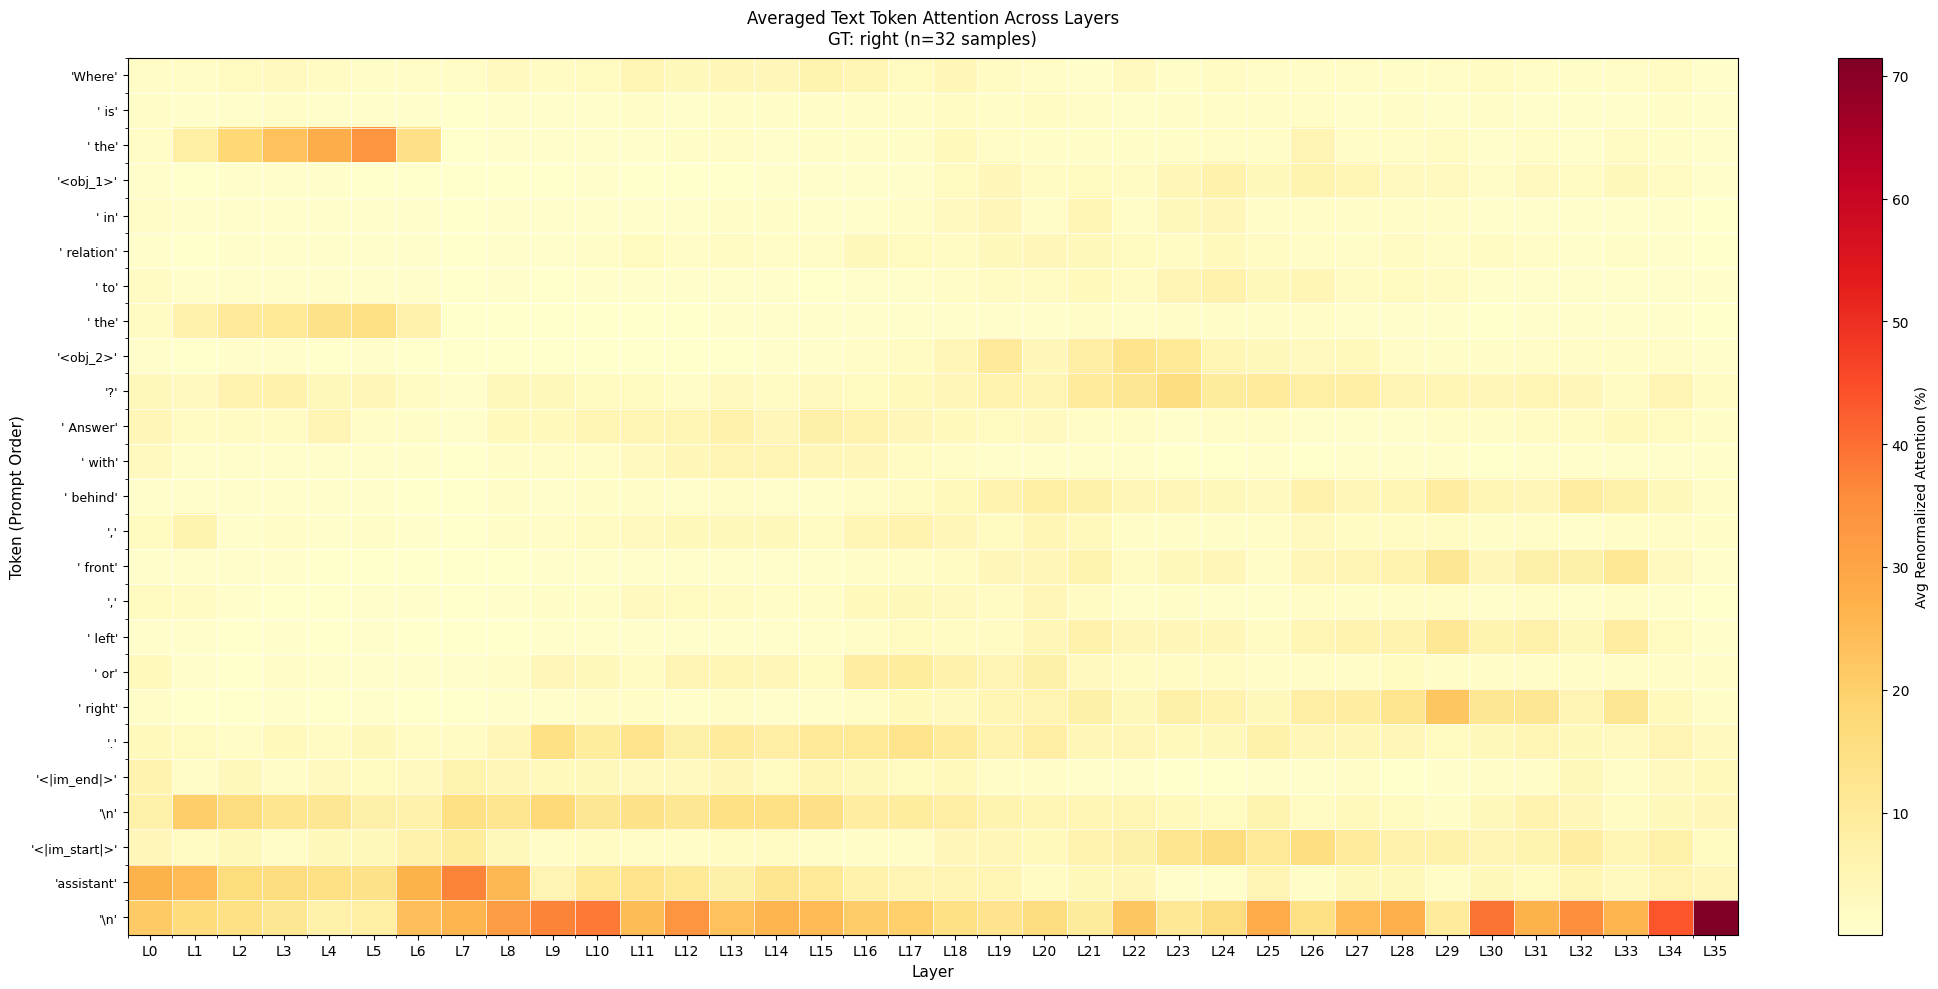

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_text_tokens_per_layer(token_df, position=None, outputs_dict=None):
    """
    Plot aggregated heatmap of renormalized attention to text tokens across layers.
    Averages across all samples (or filtered by position).

    Args:
        token_df: DataFrame with attention data
        position: Optional GT position filter (e.g., 'behind', 'in-front_of')
        outputs_dict: Optional dict with sample metadata

    Returns:
        matplotlib figure
    """
    # Filter by position if specified
    if position:
        df_filtered = token_df[token_df['GT'] == position].copy()
        n_samples = df_filtered['sample_idx'].nunique()
        print(f"Filtered to {n_samples} samples with GT={position}")
    else:
        df_filtered = token_df.copy()
        n_samples = df_filtered['sample_idx'].nunique()
        print(f"Using all {n_samples} samples")

    if len(df_filtered) == 0:
        print(f"No data found for position={position}")
        return None

    # Get unique layers
    layers = sorted(df_filtered['layer_idx'].unique())
    n_layers = len(layers)

    # Get token sequence template (from first sample, layer 0)
    first_sample = df_filtered['sample_idx'].iloc[0]
    template_data = df_filtered[
        (df_filtered['sample_idx'] == first_sample) &
        (df_filtered['layer_idx'] == 0)
    ].sort_values('rel_position')

    # Create token labels with object grouping
    token_labels = []
    for _, row in template_data.iterrows():
        rel_pos = row['rel_position']
        if rel_pos == 3:
            token_labels.append('<obj_1>')
        elif rel_pos == 8:
            token_labels.append('<obj_2>')
        else:
            token_labels.append(row['token_text'])

    n_tokens = len(token_labels)

    # Create matrix: rows = tokens, cols = layers
    matrix = np.zeros((n_tokens, n_layers))

    # For each layer and relative position, compute average attention
    for layer_idx, layer in enumerate(layers):
        layer_data = df_filtered[df_filtered['layer_idx'] == layer]

        for rel_pos in range(n_tokens):
            pos_data = layer_data[layer_data['rel_position'] == rel_pos]

            if len(pos_data) > 0:
                # Average across all samples
                avg_attention = pos_data['attention_weight_renorm_pct'].mean()
                matrix[rel_pos, layer_idx] = avg_attention

    # Create visualization
    fig, ax = plt.subplots(figsize=(max(16, n_layers * 0.6), max(10, n_tokens * 0.3)))

    # Plot heatmap
    im = ax.imshow(matrix, cmap='YlOrRd', aspect='auto', interpolation='nearest')

    # Set ticks
    ax.set_xticks(np.arange(n_layers))
    ax.set_yticks(np.arange(n_tokens))
    ax.set_xticklabels([f"L{i}" for i in layers])
    ax.set_yticklabels([repr(token) for token in token_labels], fontsize=9)

    # Rotate x labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, label='Avg Renormalized Attention (%)')

    # Create title
    if position:
        title = f"Averaged Text Token Attention Across Layers\nGT: {position} (n={n_samples} samples)"
    else:
        title = f"Averaged Text Token Attention Across Layers\nAll positions (n={n_samples} samples)"

    ax.set_title(title, fontsize=12, pad=10)
    ax.set_xlabel("Layer", fontsize=11)
    ax.set_ylabel("Token (Prompt Order)", fontsize=11)

    # Add grid
    ax.set_xticks(np.arange(n_layers) - 0.5, minor=True)
    ax.set_yticks(np.arange(n_tokens) - 0.5, minor=True)
    ax.grid(which="minor", color="white", linestyle='-', linewidth=0.5)

    plt.tight_layout()
    return fig

# Example usage:

# Plot all samples
fig = plot_text_tokens_per_layer(token_df, position="front", outputs_dict=outputs_dict)
plt.show()

fig = plot_text_tokens_per_layer(token_df, position="behind", outputs_dict=outputs_dict)
plt.show()

fig = plot_text_tokens_per_layer(token_df, position="left", outputs_dict=outputs_dict)
plt.show()

fig = plot_text_tokens_per_layer(token_df, position="right", outputs_dict=outputs_dict)
plt.show()

Using all 128 samples


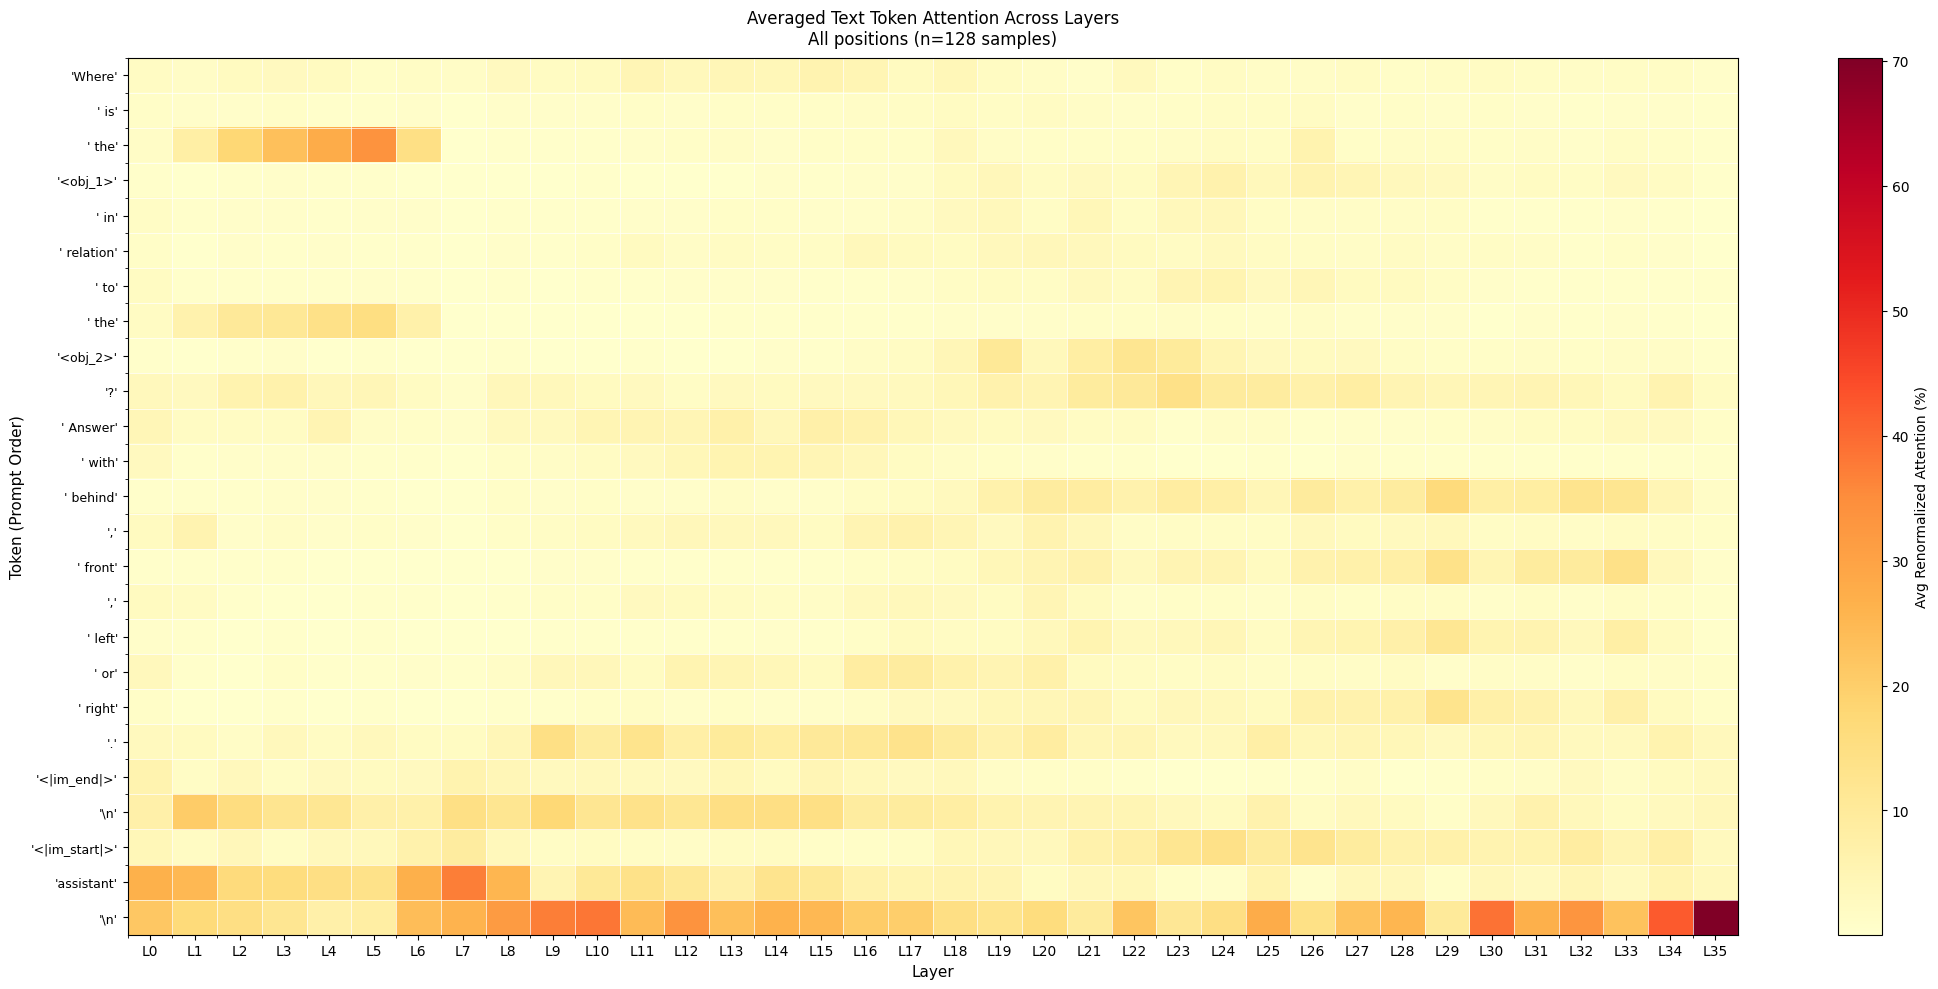

In [15]:
fig = plot_text_tokens_per_layer(token_df, outputs_dict=outputs_dict)
plt.show()

# Save attention

In [ ]:
for sample_idx, sample in tqdm(outputs_dict.items()):
    compressed_attentions = []
    for attn in sample['attentions']:
        attn = attn.squeeze()  # Remove batch dim
        attn = attn.mean(0)     # Average over heads
        compressed_attentions.append(attn)
    sample['attentions'] = tuple(compressed_attentions)  # Keep as tuple like before

In [ ]:
save_path = Path('/leonardo_work/EUHPC_D27_102/spatialmech/attn_patterns/front.pt')
torch.save(outputs_dict, save_path)
print(f"Saved to {save_path} ({save_path.stat().st_size / 1024**2:.1f} MB)")